# <center> **NLP analysis of jokes dataset**

## Table of Contents

1. **[RNN models](#5)**
	* [Pretrained embedding (word2vec)](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
     + [GRU](#sub-sub-heading-2)
	* [Glove Embedding](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
	* [Make own vocab by train word2vec model](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)




In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api
from torch.nn.utils.rnn import pad_sequence

from functools import partial

import re
import gc

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
text_columns = ['joke']

# Read data: 

In [7]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [8]:
data.head()

,joke,rank
id,,
5tz52q,I hate how you cannot even say black paint any...,1
5tz4dd,What is the difference between a Jew in Nazi G...,0
5tz319,I recently went to America..... ...and being t...,0
5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
5tz1pc,You hear about the University book store worke...,0


In [9]:
data.dropna(inplace=True)

In [10]:
data.isna().sum()

joke    0
rank    0
dtype: int64

# **Preprocessing text data**

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [11]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [12]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur "joke" in total

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(500000, 600000)
assert len(token_counts) in range(80000, 90000)
print('Correct!')

Total unique tokens : 80705
('the', 531570)
('.', 438871)
(',', 416017)
('a', 334973)
('and', 248355)
...
('uhr', 1)
('pinat', 1)
('ddr', 1)
Correct!


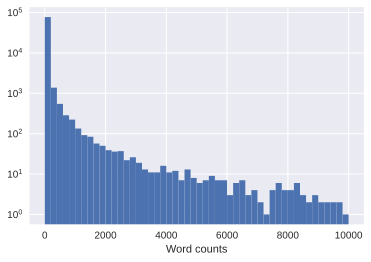

In [14]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(19000, 21000)
assert 'lol' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 20434
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [17]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [19]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf')) # общ правило - 95 квантиль
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Example:

In [20]:
print("Lines:")
print('\n'.join(data["joke"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["joke"][::100000]))

Lines:
i hate how you cannot even say black paint anymore . now i have to say " leroy can you please paint the fence ?"
why did the snowman leave his wife ?. because she got plowed by another man .

Matrix:
[[ 9138  8519  9003 20334  3066  6486 15656  2238 12898  1210   309 12348
   9138  8538 18466 15656    67 10507  3034 20334 13594 12898 18222  6923
    464]
 [19961  5387 18222 16734 10439  8787 19979   487  1977 16126  8008 13611
   2933  1173 11025   309     1     1     1     1     1     1     1     1
      1]]


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  153828
Validation size =  38458


In [22]:
TARGET_COLUMN = "rank"

In [23]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"] = as_matrix(data["joke"].values, max_len)
    
    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [31]:
make_batch(data_train[:3], max_len=10)

{'joke': tensor([[ 9138,  5648, 12320, 10200, 19875,  9696, 20228, 20078, 11953,  7959],
         [16042, 20078, 11953, 18042,   309,   552, 20287, 12545,  2543,  3012],
         [  552,  9918, 11953, 13373, 14081, 18493, 11263,   309, 16746, 13371]]),
 'rank': tensor([1, 3, 4])}

# **Classification**

In [25]:
import torch
import torch.nn as nn
import torch.functional as F

In [69]:
class BiLSTM(nn.Module):
    
    def __init__(self, n_tokens=len(tokens)):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = 5
        self.embedding = nn.Embedding(n_tokens, self.hidden_size)
        self.description_encoder = nn.Sequential(
            nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1),
          
        )
   
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        description_embeddings = self.embedding(x['joke']).permute(0, 1, 2)
      
        # description_features = self.description_encoder(description_embeddings).squeeze()
      
        # _embedding = torch.squeeze(torch.unsqueeze(description_features, 0))
        h_lstm, _ = self.lstm(description_embeddings)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [27]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [28]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cpu') # cuda

In [29]:

def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)


In [30]:
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

In [71]:
def train(model, optimizer, criterion, 
          train_loader, val_loader, 
          epochs=100, iter_per_validation=50,

          checkpoint_path="./best_checkpoint",
          save_by="accuracy"):
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None

  for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")

    for _, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    train_loader, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(train_loader) // BATCH_SIZE
        ):
          # print(batch['joke'].shape)
          # return 

          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(batch)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs,  batch[TARGET_COLUMN])
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 0:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for _, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    val_loader, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(val_loader) // BATCH_SIZE
        ):

                    # Forward propagation
                    outputs = model(batch)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(batch[TARGET_COLUMN])
                    
                    correct += (predicted == batch[TARGET_COLUMN]).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(iteration)
                accuracy_list.append(accuracy)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)

  return iteration_list, loss_list, accuracy_list


In [70]:
model = BiLSTM().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [72]:
it, losses, acs = train(model,
                        optimizer,
                        criterion,
                        data_train, 
                        data_val,
                        3, 
                        checkpoint_path='./lstm_best_checkpoint')

EPOCH: 0


  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 50  Loss: 194.72332763671875  Accuracy: 32.72661209106445 %
Saving model and optimizer state at iteration 50 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 100  Loss: 190.8301544189453  Accuracy: 34.64558792114258 %
Saving model and optimizer state at iteration 100 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 150  Loss: 199.58370971679688  Accuracy: 34.64298629760742 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 200  Loss: 196.69248962402344  Accuracy: 34.83540344238281 %
Saving model and optimizer state at iteration 200 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 250  Loss: 199.89724731445312  Accuracy: 34.978416442871094 %
Saving model and optimizer state at iteration 250 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 300  Loss: 194.05877685546875  Accuracy: 34.93161392211914 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 350  Loss: 197.17123413085938  Accuracy: 35.144832611083984 %
Saving model and optimizer state at iteration 350 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 400  Loss: 203.40098571777344  Accuracy: 35.36585235595703 %
Saving model and optimizer state at iteration 400 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 450  Loss: 193.33721923828125  Accuracy: 34.952415466308594 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 500  Loss: 194.82167053222656  Accuracy: 35.373653411865234 %
Saving model and optimizer state at iteration 500 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 550  Loss: 196.51467895507812  Accuracy: 35.51926803588867 %
Saving model and optimizer state at iteration 550 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 600  Loss: 197.64425659179688  Accuracy: 35.566070556640625 %
Saving model and optimizer state at iteration 600 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 650  Loss: 202.5335235595703  Accuracy: 35.589473724365234 %
Saving model and optimizer state at iteration 650 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 700  Loss: 194.38137817382812  Accuracy: 35.58687210083008 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 750  Loss: 189.04148864746094  Accuracy: 35.54787063598633 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 800  Loss: 201.76918029785156  Accuracy: 35.95350646972656 %
Saving model and optimizer state at iteration 800 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 850  Loss: 202.16702270507812  Accuracy: 35.719486236572266 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 900  Loss: 196.75738525390625  Accuracy: 35.321651458740234 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 950  Loss: 198.02627563476562  Accuracy: 35.78709411621094 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1000  Loss: 191.5569610595703  Accuracy: 35.97690963745117 %
Saving model and optimizer state at iteration 1000 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1050  Loss: 186.4442901611328  Accuracy: 35.779293060302734 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1100  Loss: 185.58815002441406  Accuracy: 35.83649826049805 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1150  Loss: 195.64212036132812  Accuracy: 36.203128814697266 %
Saving model and optimizer state at iteration 1150 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1200  Loss: 191.2372283935547  Accuracy: 36.16152572631836 %
EPOCH: 1


  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1250  Loss: 187.75164794921875  Accuracy: 36.22913360595703 %
Saving model and optimizer state at iteration 1250 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1300  Loss: 182.5963592529297  Accuracy: 36.23173141479492 %
Saving model and optimizer state at iteration 1300 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1350  Loss: 183.94680786132812  Accuracy: 35.80009460449219 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1400  Loss: 184.76327514648438  Accuracy: 36.19792938232422 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1450  Loss: 186.73953247070312  Accuracy: 36.42415237426758 %
Saving model and optimizer state at iteration 1450 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1500  Loss: 187.37750244140625  Accuracy: 36.18232727050781 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1550  Loss: 196.6289825439453  Accuracy: 36.16152572631836 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1600  Loss: 190.14320373535156  Accuracy: 35.89630126953125 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1650  Loss: 196.1641082763672  Accuracy: 36.5229606628418 %
Saving model and optimizer state at iteration 1650 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1700  Loss: 185.2454833984375  Accuracy: 36.57756423950195 %
Saving model and optimizer state at iteration 1700 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1750  Loss: 189.35389709472656  Accuracy: 36.634769439697266 %
Saving model and optimizer state at iteration 1750 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1800  Loss: 195.1694793701172  Accuracy: 36.7907829284668 %
Saving model and optimizer state at iteration 1800 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1850  Loss: 197.6893768310547  Accuracy: 36.7725830078125 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1900  Loss: 194.38917541503906  Accuracy: 36.837589263916016 %
Saving model and optimizer state at iteration 1900 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 1950  Loss: 193.28138732910156  Accuracy: 36.27073669433594 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2000  Loss: 189.9560546875  Accuracy: 36.58796691894531 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2050  Loss: 187.01995849609375  Accuracy: 36.84539031982422 %
Saving model and optimizer state at iteration 2050 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2100  Loss: 190.92074584960938  Accuracy: 36.860992431640625 %
Saving model and optimizer state at iteration 2100 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2150  Loss: 183.7908935546875  Accuracy: 36.671173095703125 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2200  Loss: 183.75924682617188  Accuracy: 36.897396087646484 %
Saving model and optimizer state at iteration 2200 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2250  Loss: 185.2243194580078  Accuracy: 36.67637252807617 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2300  Loss: 180.84539794921875  Accuracy: 37.03520584106445 %
Saving model and optimizer state at iteration 2300 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2350  Loss: 191.35794067382812  Accuracy: 37.11061477661133 %
Saving model and optimizer state at iteration 2350 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2400  Loss: 189.92567443847656  Accuracy: 37.23542404174805 %
Saving model and optimizer state at iteration 2400 to ./lstm_best_checkpoint
EPOCH: 2


  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2450  Loss: 178.4645538330078  Accuracy: 37.13401794433594 %


  0%|          | 0/300 [00:01<?, ?it/s]

Iteration: 2500  Loss: 183.18508911132812  Accuracy: 36.756980895996094 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2550  Loss: 184.3309783935547  Accuracy: 36.88179397583008 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2600  Loss: 186.99526977539062  Accuracy: 36.98320388793945 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2650  Loss: 181.8090057373047  Accuracy: 36.886993408203125 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2700  Loss: 182.56289672851562  Accuracy: 37.19382095336914 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2750  Loss: 181.9241943359375  Accuracy: 37.19382095336914 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2800  Loss: 194.8302764892578  Accuracy: 37.33423614501953 %
Saving model and optimizer state at iteration 2800 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2850  Loss: 185.5593719482422  Accuracy: 37.258827209472656 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2900  Loss: 174.85227966308594  Accuracy: 37.152217864990234 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 2950  Loss: 187.2498779296875  Accuracy: 37.282230377197266 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3000  Loss: 188.9459228515625  Accuracy: 36.72837829589844 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3050  Loss: 190.60914611816406  Accuracy: 37.26662826538086 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3100  Loss: 183.1412353515625  Accuracy: 37.13141632080078 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3150  Loss: 189.84925842285156  Accuracy: 36.985801696777344 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3200  Loss: 192.4500274658203  Accuracy: 37.381038665771484 %
Saving model and optimizer state at iteration 3200 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3250  Loss: 193.0109405517578  Accuracy: 36.985801696777344 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3300  Loss: 188.72447204589844  Accuracy: 36.801185607910156 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3350  Loss: 174.3116912841797  Accuracy: 37.394039154052734 %
Saving model and optimizer state at iteration 3350 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3400  Loss: 192.30506896972656  Accuracy: 37.29783248901367 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3450  Loss: 187.17872619628906  Accuracy: 37.46684646606445 %
Saving model and optimizer state at iteration 3450 to ./lstm_best_checkpoint


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3500  Loss: 178.90359497070312  Accuracy: 37.40184020996094 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3550  Loss: 175.74505615234375  Accuracy: 37.31343460083008 %


  0%|          | 0/300 [00:00<?, ?it/s]

Iteration: 3600  Loss: 180.5774383544922  Accuracy: 36.53076171875 %


**Visualization**

In [73]:
def draw_visualization(iteration_list, loss_list, accuracy_list):
    # visualization loss 
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Number of iteration")
    plt.show()

    # visualization accuracy 
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of iteration")
    plt.show()

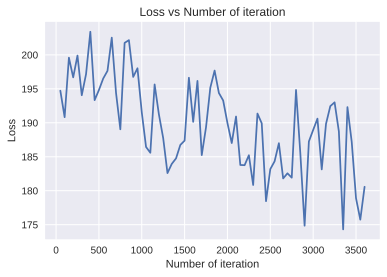

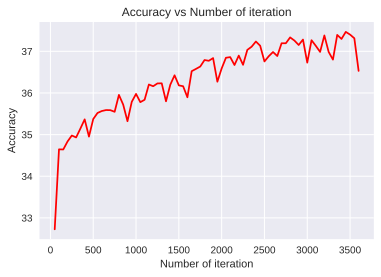

In [74]:
draw_visualization(it, losses, acs)

**Prediction**

In [75]:
_ = load_checkpoint('./lstm_best_checkpoint', model, optimizer)

Loading checkpoint './lstm_best_checkpoint'
Loaded checkpoint './lstm_best_checkpoint' from iteration 3450


In [ ]:
all_preds = []
for _, batch in tqdm.notebook.tqdm(enumerate(
      iterate_minibatches(
              data_val, 
              batch_size=BATCH_SIZE, 
              device=DEVICE)), 
          total=len(data_val) // BATCH_SIZE
  ):

    with torch.no_grad(): 
      test_outputs = model(batch)
      all_preds.append(test_outputs)



In [79]:
features = torch.cat(
            all_preds, dim=0)

In [80]:
%cd /content/drive/My Drive/NLP_humor/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

/content/drive/My Drive/NLP_humor


In [81]:
def calc_metrics(test_label, preds):
    classes_names = ['0', '1', '2', '3', '4']
    num_classes = 5

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))


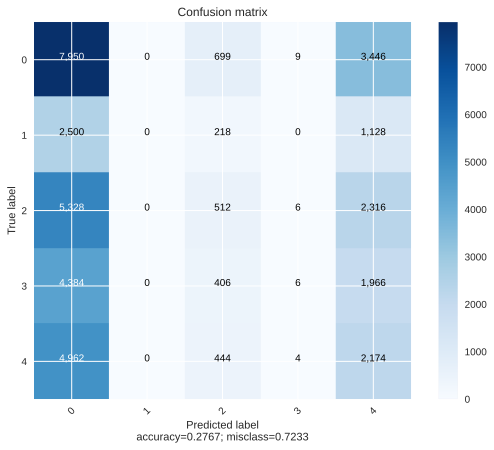

Accuracy: 0.27672 
Balanced accuracy: 0.20142 
Multiclass f1-score: 
    micro: 0.27672 
    macro: 0.15211 
    weighted: 0.20161


Classification report:

              precision    recall  f1-score   support

           0    0.31643   0.65681   0.42710     12104
           1    0.00000   0.00000   0.00000      3846
           2    0.22466   0.06273   0.09807      8162
           3    0.24000   0.00089   0.00177      6762
           4    0.19710   0.28666   0.23359      7584

    accuracy                        0.27672     38458
   macro avg    0.19564   0.20142   0.15211     38458
weighted avg    0.22834   0.27672   0.20161     38458



In [82]:
predicted = torch.max(features.data,1)[1]  # [1]

calc_metrics(data_val['rank'], predicted)